In [1]:
import datetime as dt
import pandas as pd
#!pip install yfinance
import yfinance as yf

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import to_date
from pyspark.ml.evaluation import RegressionEvaluator


In [3]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [4]:
# SparkSession başlatma
spark = SparkSession.builder.appName("NVDA Price Prediction").getOrCreate()

24/04/02 22:16:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Veriyi yükleme ve DataFrame oluşturma
data = spark.read.csv("file:///home/hduser/Desktop/NVDA/NVDA_histrical_data.csv", header=True, inferSchema=True)

# 'Date' sütununu tarih tipine dönüştürme 
data = data.withColumn("Date", to_date(data["Date"]))

In [6]:
data.show(5)

+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|      Date|               Open|               High|                Low|              Close|          Adj Close|  Volume|
+----------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+
|1999-03-22| 0.4466150104999542|0.44791701436042786|0.42447900772094727|0.42447900772094727| 0.3893755376338959| 3667200|
|1999-03-23|0.42708298563957214|0.42708298563957214|           0.390625| 0.3984380066394806| 0.3654879927635193|16396800|
|1999-03-24|0.39583298563957214| 0.3984380066394806|0.38020798563957214|0.39583298563957214| 0.3630985617637634| 6086400|
|1999-03-25| 0.3945310115814209|0.41666701436042786|0.39322900772094727|0.40104201436042786|0.36787667870521545| 4032000|
|1999-03-26|            0.40625|             0.4375|            0.40625|0.43619799613952637|0.40012532472610474| 8827200|
+----------+------------

In [7]:
spark.createDataFrame(data.tail(5)).show()

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+
|2024-03-15|869.2999877929688|895.4600219726562|862.5700073242188|878.3699951171875|878.3699951171875|64019300|
|2024-03-18|903.8800048828125|924.0499877929688|870.8499755859375|884.5499877929688|884.5499877929688|66897600|
|2024-03-19|            867.0|905.4400024414062|850.0999755859375|  893.97998046875|  893.97998046875|67217100|
|2024-03-20| 897.969970703125|904.0999755859375|  882.22998046875| 903.719970703125| 903.719970703125|47906300|
|2024-03-21|            923.0|  926.47998046875|904.0499877929688|914.3499755859375|914.3499755859375|48037200|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--

In [8]:
# 'Close' dışındaki tüm sütunları at
df_org = data.select("Date", "Close")

# İlk 5 satırı göstermek için
df_org.show(5)


+----------+-------------------+
|      Date|              Close|
+----------+-------------------+
|1999-03-22|0.42447900772094727|
|1999-03-23| 0.3984380066394806|
|1999-03-24|0.39583298563957214|
|1999-03-25|0.40104201436042786|
|1999-03-26|0.43619799613952637|
+----------+-------------------+
only showing top 5 rows



In [9]:
df = df_org

In [10]:
from pyspark.sql.functions import col, count, when

# Her bir sütun için eksik değer sayısını hesaplama
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+-----+
|Date|Close|
+----+-----+
|   0|    0|
+----+-----+



In [11]:
# 'Close' sütunu ve 'Date' sütunu ile sınırlı DataFrame'i CSV olarak kaydet
#df.write.csv("file:///home/hduser/Desktop/NVDA/NVDA.csv", header=True)


Uyarıları tamamen kapatmanın bir yolu olmasa da, günlükleri daha az ayrıntılı hale getirerek uyarıların gösterilmesini azaltabilirsiniz. Bu, Spark'ın günlük seviyesini ayarlayarak yapılabilir. Örneğin, günlük seviyesini "ERROR" olarak ayarlamak yalnızca hata mesajlarının gösterilmesini sağlayacaktır.

In [12]:
spark.sparkContext.setLogLevel("ERROR")

1. Veri Setinin Yüklenmesi ve Öznitelik Oluşturma

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag,col, to_date, dayofweek
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
# Spark oturumunu başlatma
spark = SparkSession.builder.appName("Stock Price Forecasting").getOrCreate()

# Gecikmeli öznitelikler ekleyin
for i in range(1, 6):
    df = df.withColumn(f"lag_{i}", lag(col("Close"), i).over(Window.orderBy("Date")))

# Haftanın günü gibi tarih özniteliklerini ekleyin
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))

# Eğitim için kullanılacak özniteliklerin listesini oluştur
input_cols = [f"lag_{i}" for i in range(1, 6)] + ['DayOfWeek']

In [14]:
from pyspark.sql import functions as F

for i in range(1, 6):
    # 'lag' sütunlarını mevcut 'Close' değeriyle doldurun
    df = df.withColumn(f"lag_{i}", F.coalesce(df[f"lag_{i}"], df["Close"]))

In [15]:
#df.show(6)

In [16]:
from pyspark.sql.functions import dayofweek
# 'DayOfWeek' sütunu için eksik değerleri doldurun
#df = df.withColumn('DayOfWeek', dayofweek(df['Date']))
# 'DayOfWeek' sütunu için `null` değerleri kontrol edin ve doldurun
#df = df.na.fill({'DayOfWeek': 0})

# VectorAssembler'ı tekrar çalıştırın
vectorAssembler = VectorAssembler(inputCols=input_cols, outputCol='features')
df = vectorAssembler.transform(df)

# Veri setini eğitim ve test olarak ayırma
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


2. Model Eğitimi ve Katsayıların Gözlemlenmesi

In [17]:
from pyspark.ml.regression import LinearRegression

# Modeli tanımla ve eğit
lr = LinearRegression(featuresCol="features", labelCol="Close")
model = lr.fit(train_df)

# Eğitim ve test setleri üzerinde tahminler yap
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Model katsayılarını ve intercept değerini yazdır
print("Intercept:", model.intercept)
print("Coefficients:")
for i, coeff in enumerate(model.coefficients):
    print(f"lag_{i+1} coefficient: {coeff}")


Intercept: 0.04988244110402498
Coefficients:
lag_1 coefficient: 0.9337373195024947
lag_2 coefficient: -0.04444383555935839
lag_3 coefficient: 0.13583450907517358
lag_4 coefficient: -0.042829205807827314
lag_5 coefficient: 0.022714581792605455
lag_6 coefficient: -0.03340973729783707


3. Model Değerlendirme (RMSE ve MSE)

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE ve MSE değerlendirici tanımla ve hesapla
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close")

train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mse = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
test_mse = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})

print(f"Train RMSE: {train_rmse}, Train MSE: {train_mse}")
print(f"Test RMSE: {test_rmse}, Test MSE: {test_mse}")


Train RMSE: 3.81371978892459, Train MSE: 14.544458628435018
Test RMSE: 3.0538706461634777, Test MSE: 9.326125923498937


4. Gelecekteki 5 Gün İçin Tahminlerin Yapılması

In [19]:
import datetime as dt

last_row = train_df.orderBy(F.desc("Date")).first()
today_date = last_row["Date"]
#end = dt.datetime.now()
end = dt.datetime.now().date()
# Hafta içi ve toplam günlerin sayısını saklamak için bir değişken tanımla 
# Bu degiskenlere gelecek degerler bir gun oncenin olacagi icin -1'den baslatiyoruz
weekdays_count = -1
totol_days = -1
# Tarih aralığını döngüye alarak her gün için hafta içi olup olmadığını kontrol et
current_date = today_date
while current_date < end:
    totol_days += 1
    # Eğer gün hafta içi ise, weekdays_count değişkenini artır
    if current_date.weekday() < 5:  # Pazartesi (0) - Cuma (4)
        weekdays_count += 1
    # Bir sonraki günü al
    current_date += dt.timedelta(days=1)

# Hafta içi günlerin sayısını yazdır
print("Hafta içi günlerin toplam sayısı:", weekdays_count)
print("Toplam geçen gün sayısı:", totol_days)

Hafta içi günlerin toplam sayısı: 7
Toplam geçen gün sayısı: 11


In [20]:
from datetime import datetime, timedelta
# Gelecek tarihler için bir liste oluşturun, hafta sonlarını atlayın
future_dates = []
for i in range(1, totol_days+2):
    next_day = today_date + timedelta(days=i)
    if next_day.weekday() < 5:  # 0: Pazartesi, ..., 4: Cuma
        future_dates.append(next_day)
future_dates

[datetime.date(2024, 3, 22),
 datetime.date(2024, 3, 25),
 datetime.date(2024, 3, 26),
 datetime.date(2024, 3, 27),
 datetime.date(2024, 3, 28),
 datetime.date(2024, 3, 29),
 datetime.date(2024, 4, 1),
 datetime.date(2024, 4, 2)]

In [21]:
# Modelin en son tahminlerinden ve bilinen değerlerden yeni gecikmeli öznitelikler yaratma
last_known_values = [last_row["Close"]] + [last_row[f"lag_{i}"] for i in range(1, 5)]

In [22]:
from pyspark.sql.functions import lit, array
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import to_date, max
from datetime import datetime, timedelta

# Modeli ve son bilinen verileri yükleyin
#trained_model = # Eğitilmiş modelinizin yüklendiği yer
#last_known_values = # Son bilinen lag ve close değerleri


# Tahmin yapmak istediğiniz gün sayısını belirleyin
future_days = len(future_dates)  # Örneğin, future_dates uzunlugu kadar tahmin etmek istiyorsanız

# Veri setindeki en son tarihi al
last_date_row = df.select(max(to_date("Date"))).collect()
current_date = last_date_row[0][0]
#current_date = datetime.now()  # Mevcut tarihi kullanarak tahminler yapın

# Gelecek tarihler için boş bir DataFrame oluşturun
#future_dates = [current_date + timedelta(days=i) for i in range(1, future_days + 1)]
future_predictions = []


# Örnek olarak, eğer modeliniz 5 gecikme özelliği kullanıyorsa (lag_1, lag_2, ... lag_5),
# ve last_known_values son bilinen 'Close' değeri ve 5 gecikme özelliğini içeriyorsa:
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

# Bu değerleri kullanarak yeni özellikler vektörünü oluşturun
#new_features = [last_known_values[i] for i in lag_features]

# Döngü ile tahminleri yapın
for future_date in future_dates:
    # Yeni özellikler vektörünü oluşturun
    new_features = last_known_values[-len(lag_features):] + [last_known_values[0]]
    new_features_vector = Vectors.dense(new_features)
    
    # Yeni veri setini oluşturun ve tahmin yapın
    df_to_predict = spark.createDataFrame([(future_date, new_features_vector)], ["Date", "features"])
    prediction = model.transform(df_to_predict)
    
    # Tahmin edilen değeri alın ve sonuç listesine ekleyin
    predicted_close = prediction.select("prediction").collect()[0]["prediction"]
    future_predictions.append((future_date, predicted_close))
    
    # Sonraki tahmin için 'lag' değerlerini güncelleyin
    last_known_values = new_features[1:] + [predicted_close]

# Tahminleri içeren DataFrame'i oluşturun
predictions_df = spark.createDataFrame(future_predictions, ["Date", "Predicted_Close"])
predictions_df.show()


+----------+-----------------+
|      Date|  Predicted_Close|
+----------+-----------------+
|2024-03-22|886.6001688734106|
|2024-03-25|865.5773379209504|
|2024-03-26|851.4134418426622|
|2024-03-27|856.2187728958244|
|2024-03-28|834.7049997172702|
|2024-03-29|821.4150077861905|
|2024-04-01|822.9755988650437|
|2024-04-02|801.0484180375386|
+----------+-----------------+



In [23]:
spark.createDataFrame(df_org.tail(5)).show()

+----------+-----------------+
|      Date|            Close|
+----------+-----------------+
|2024-03-15|878.3699951171875|
|2024-03-18|884.5499877929688|
|2024-03-19|  893.97998046875|
|2024-03-20| 903.719970703125|
|2024-03-21|914.3499755859375|
+----------+-----------------+



In [24]:
import datetime as dt
import pandas as pd
#pip install yfinance
import yfinance as yf
import numpy as np

In [25]:
end = dt.datetime.now()
#end = dt.datetime(2024,3,27)
start = dt.datetime(2024,3,22)
start,end

(datetime.datetime(2024, 3, 22, 0, 0),
 datetime.datetime(2024, 4, 2, 22, 16, 45, 285953))

In [26]:
df_real = yf.download("NVDA",start,end)
df_real_close = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_close

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005
2024-04-02,894.520020


In [27]:
# Spark DataFrame'ini pandas DataFrame'ine dönüştürme
predictions_pandas_df = predictions_df.toPandas()
# 'Date' sütununu index olarak atama
predictions_pandas_df = predictions_pandas_df.set_index('Date')
predictions_pandas_df

,Predicted_Close
Date,
2024-03-22,886.600169
2024-03-25,865.577338
2024-03-26,851.413442
2024-03-27,856.218773
2024-03-28,834.705000
2024-03-29,821.415008
2024-04-01,822.975599
2024-04-02,801.048418


In [28]:
#!pip install plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected = True)
pd.options.plotting.backend = "plotly"

In [29]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df = df_real.join(predictions_pandas_df, how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Predicted_Close
Date,,,,,,,
2024-03-22,911.409973,947.780029,908.340027,942.890015,942.890015,58521500,886.600169
2024-03-25,939.409973,967.659973,935.099976,950.020020,950.020020,55213600,865.577338
2024-03-26,958.510010,963.750000,925.020020,925.609985,925.609985,51364800,851.413442
2024-03-27,931.119995,932.400024,891.229980,902.500000,902.500000,58606700,856.218773
2024-03-28,900.000000,913.000000,891.929993,903.559998,903.559998,43521200,834.705000
2024-04-01,902.989990,922.250000,892.039978,903.630005,903.630005,45244100,822.975599
2024-04-02,884.700012,900.940002,876.200012,894.520020,894.520020,42640126,801.048418


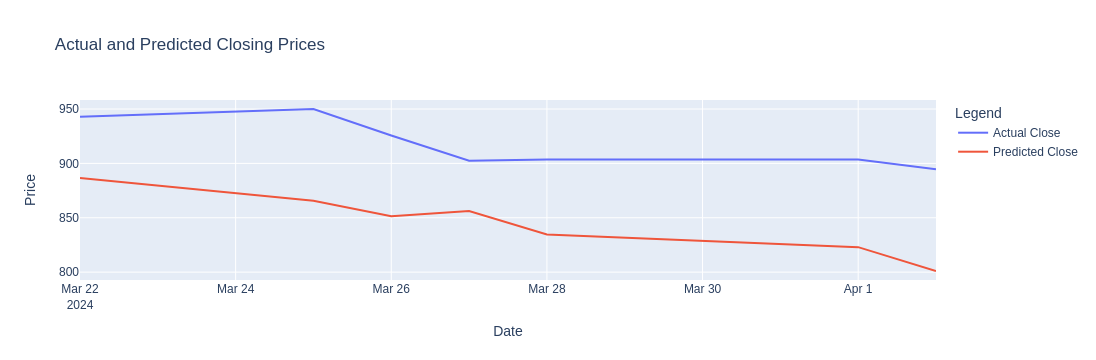

In [30]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace1 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Close'],
    mode='lines',
    name='Actual Close'
)

trace2 = go.Scatter(
    x=merged_df.index,
    y=merged_df['Predicted_Close'],
    mode='lines',
    name='Predicted Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [31]:
# Hata metriklerini hesaplayın
errors = merged_df['Close'] - merged_df['Predicted_Close']
mae = np.mean(np.abs(errors))
mse = np.mean(np.square(errors))
rmse = np.sqrt(mse)

print(f"MAE: {mae}") # Mean Absolute Error - MAE
print(f"MSE: {mse}") # Mean Squared Error - MSE
print(f"RMSE: {rmse}") # Root Mean Squared Error - RMSE

MAE: 72.02732905017231
MSE: 5418.468069922589
RMSE: 73.61024432728497


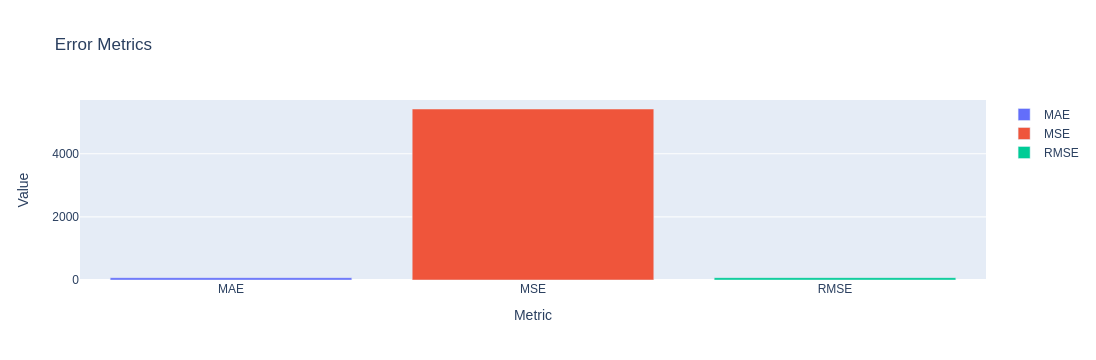

In [32]:
import plotly.graph_objs as go

# Örnek veriler
hata = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae, mse, rmse]
}
# Bar grafiği oluşturun ve efsane (legend) özelliğini aktifleştirin
traces = []
for metric, value in zip(hata['Metrics'], hata['Values']):
    traces.append(go.Bar(x=[metric], y=[value], name=metric))

fig = go.Figure(data=traces)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()

# ARIMA

In [33]:
df_arima = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [34]:
df_arima.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [35]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_arima["Date"] = pd.to_datetime(df_arima["Date"])
df_arima.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_arima.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [36]:
#!pip install statsmodels

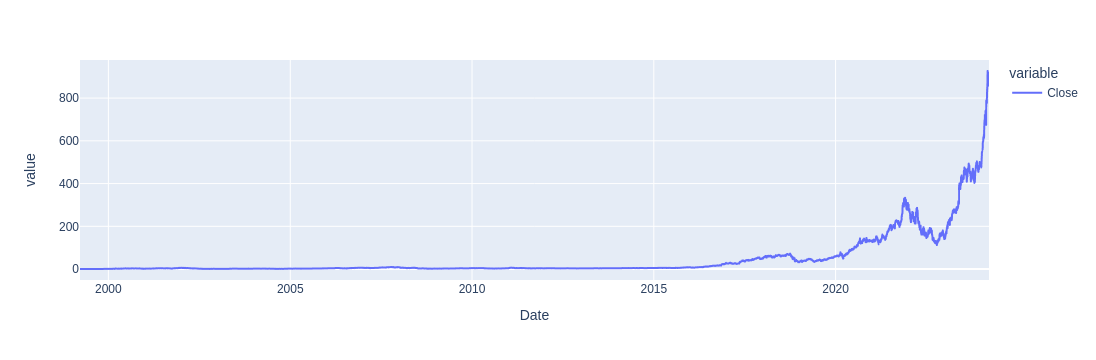

In [37]:
df_arima["Close"].plot()

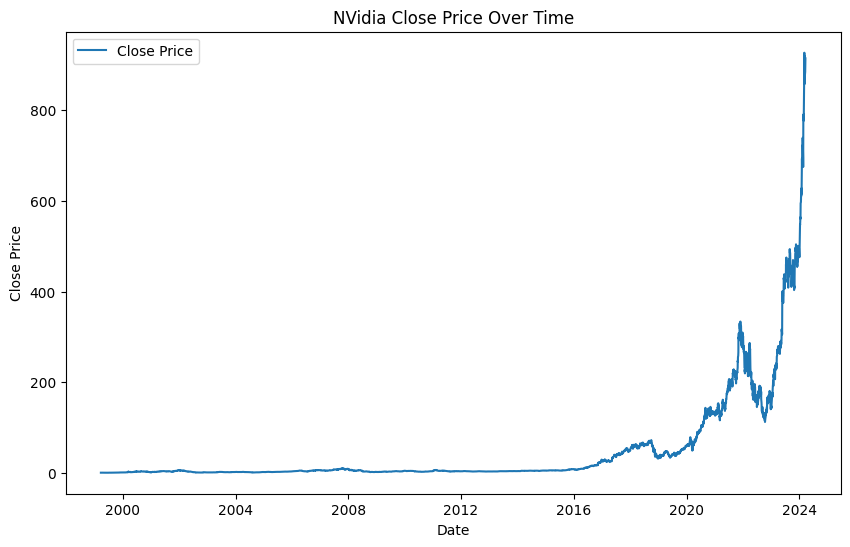

In [38]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Zaman serisinin grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(df_arima.index, df_arima["Close"], label="Close Price")
plt.title("NVidia Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [39]:
# Durağanlık testi yapalım (Augmented Dickey-Fuller testi)
adf_test = adfuller(df_arima["Close"])
adf_test_output = {"Test Statistic": adf_test[0], "p-value": adf_test[1], "Critical Values": adf_test[4]}

adf_test_output


{'Test Statistic': 5.155957114554979,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.43139554655334,
  '5%': -2.8620020389491527,
  '10%': -2.5670159403767285}}

In [40]:
# İlk farkı alalım
df_diff = df_arima["Close"].diff().dropna()


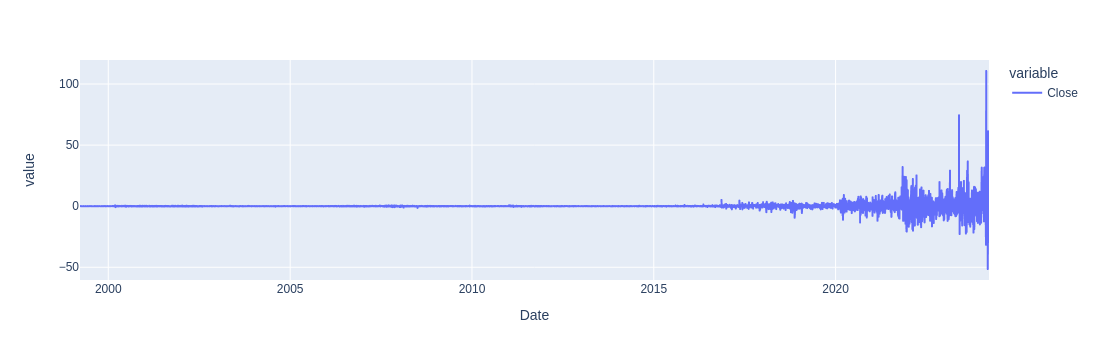

In [41]:
df_diff.plot()

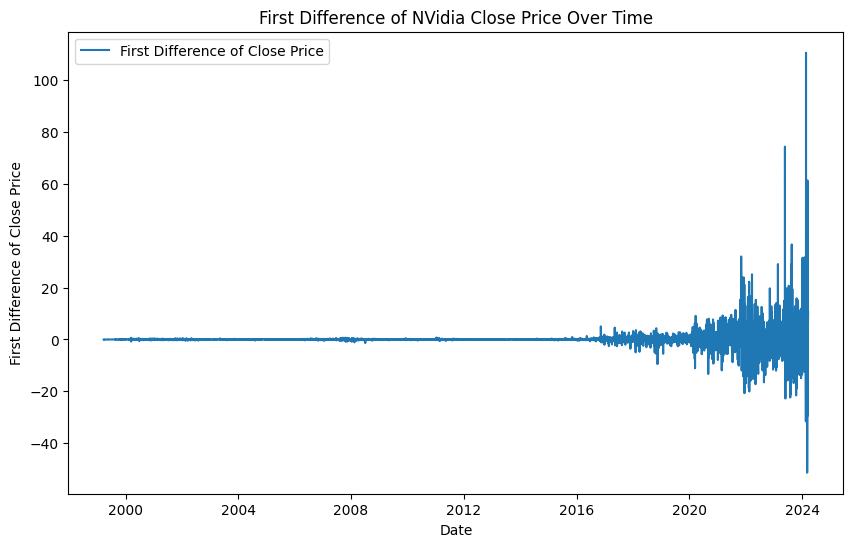

In [42]:
# İlk farkın grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(df_diff.index, df_diff, label="First Difference of Close Price")
plt.title("First Difference of NVidia Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("First Difference of Close Price")
plt.legend()
plt.show()

In [43]:
# Yeniden durağanlık testi yapalım
adf_test_diff = adfuller(df_diff)
adf_test_diff_output = {"Test Statistic": adf_test_diff[0], "p-value": adf_test_diff[1], "Critical Values": adf_test_diff[4]}

adf_test_diff_output


{'Test Statistic': -5.757858629267697,
 'p-value': 5.76359951481798e-07,
 'Critical Values': {'1%': -3.431395379411139,
  '5%': -2.8620019651000943,
  '10%': -2.567015901065109}}

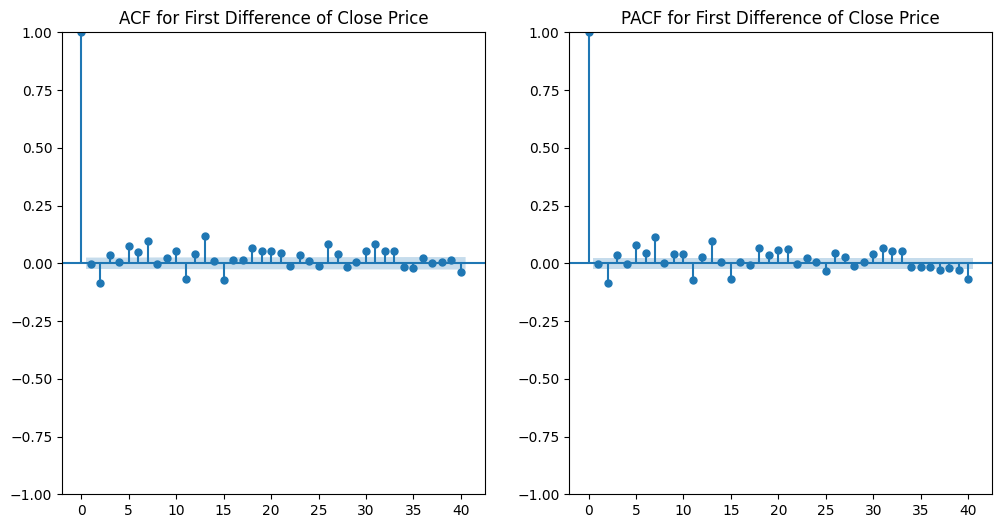

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF ve PACF grafiklerini çizdirelim
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Otomatik Çapraz Korelasyon Fonksiyonu (ACF)
plot_acf(df_diff, ax=ax1, lags=40, alpha=0.05)
ax1.set_title("ACF for First Difference of Close Price")

# Kısmi Otomatik Çapraz Korelasyon Fonksiyonu (PACF)
plot_pacf(df_diff, ax=ax2, lags=40, alpha=0.05)
ax2.set_title("PACF for First Difference of Close Price")

plt.show()


In [45]:
from statsmodels.tsa.arima.model import ARIMA
df_arima = df_arima.asfreq('B')
# ARIMA modelini kurma ve eğitme
model = ARIMA(df_arima["Close"], order=(1, 1, 1))

model_fit = model.fit()

# Model özeti
model_summary = model_fit.summary()

print(model_summary)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6524
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17217.616
Date:                Tue, 02 Apr 2024   AIC                          34441.231
Time:                        22:16:48   BIC                          34461.581
Sample:                    03-22-1999   HQIC                         34448.268
                         - 03-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9080      0.006   -158.403      0.000      -0.919      -0.897
ma.L1          0.9537      0.005    206.723      0.000       0.945       0.963
sigma2        13.5654      0.030    446.404      0.0

In [46]:
# Pandas kullanarak iş günleri sayısını ve toplam gün sayısını hesaplayacağız
import pandas as pd
import datetime as dt


start_arima = df_arima.index.max()

# Bugünün tarihini alalım
end_arima = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# İş günlerini hesaplayalım
business_days = pd.bdate_range(start=start_arima, end=end_arima)

# İş günleri ve toplam gün sayısını -1 ile başlatalım çünkü başlangıç gününü saymıyoruz
weekdays_count_arima = len(business_days) - 1
total_days_arima = (end_arima - start_arima).days - 1

weekdays_count_arima, total_days_arima


(8, 11)

In [47]:
forecast_steps = weekdays_count_arima # sonraki is gunleri 
# Sonraki 6 iş günü için tahmin yapma
forecast = model_fit.forecast(steps=forecast_steps)

# Doğru tarih aralığını ve tahminleri alalım
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=forecast_steps+1, freq='B')
forecast_values = model_fit.get_forecast(steps=forecast_steps-1).predicted_mean

# Uyuşmazlık olmaması için tarihlerin ve tahminlerin sayısının aynı olduğundan emin olalım
forecast_dates = forecast_dates[1:]  # İlk tarihi hariç tutuyoruz çünkü tahmin başlangıcı mevcut verinin sonrası olmalı

# Sonuçları bir DataFrame'e dönüştürüyoruz
df_arima_forecast = pd.DataFrame({"Predicted_Close": forecast_values })
df_arima_forecast.rename_axis("Date", inplace=True)
df_arima_forecast

,Predicted_Close
Date,
2024-03-22,915.961616
2024-03-25,914.498229
2024-03-26,915.827000
2024-03-27,914.620462
2024-03-28,915.716012
2024-03-29,914.721241
2024-04-01,915.624504


In [48]:
df_real = yf.download("NVDA",start,end_arima)
df_real_arima = df_real.drop(columns=["Open","High","Low","Adj Close","Volume"])
df_real_arima

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005


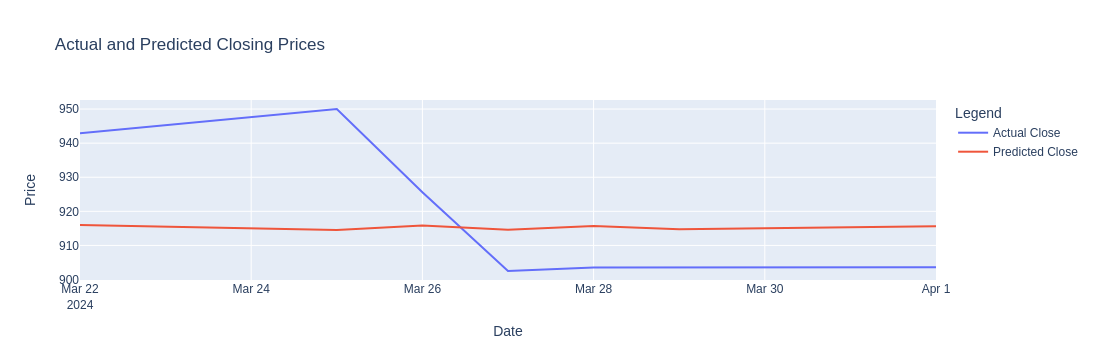

In [49]:
import plotly.graph_objs as go

# Create Plotly Scatter objects
trace_arima_actual = go.Scatter(
    x=df_real_arima.index,
    y=df_real_arima['Close'],
    mode='lines',
    name='Actual Close'
)

trace_arima_predicted = go.Scatter(
    x=df_arima_forecast.index,
    y=df_arima_forecast['Predicted_Close'],
    mode='lines',
    name='Predicted Close'
)

# Create and show the combined graph
fig = go.Figure(data=[trace_arima_actual, trace_arima_predicted])
#fig = go.Figure(data=[trace_arima_actual])
fig.update_layout(
    title='Actual and Predicted Closing Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

fig.show()


In [50]:
# Index üzerinden birleştirme yapın
# Bu, aynı tarihlerdeki verileri yan yana getirecektir
merged_df_arima = df_real_arima.join(df_arima_forecast, how='inner')
merged_df_arima

,Close,Predicted_Close
Date,,
2024-03-22,942.890015,915.961616
2024-03-25,950.020020,914.498229
2024-03-26,925.609985,915.827000
2024-03-27,902.500000,914.620462
2024-03-28,903.559998,915.716012
2024-04-01,903.630005,915.624504


In [51]:
# Hata metriklerini hesaplayın
errors = merged_df_arima['Close'] - merged_df_arima['Predicted_Close']
mae_arima = np.mean(np.abs(errors))
mse_arima = np.mean(np.square(errors))
rmse_arima = np.sqrt(mse_arima)

print(f"MAE: {mae_arima}") # Mean Absolute Error - MAE
print(f"MSE: {mse_arima}") # Mean Squared Error - MSE
print(f"RMSE: {rmse_arima}") # Root Mean Squared Error - RMSE

MAE: 18.084024743352376
MSE: 420.1975495838395
RMSE: 20.498720681638634


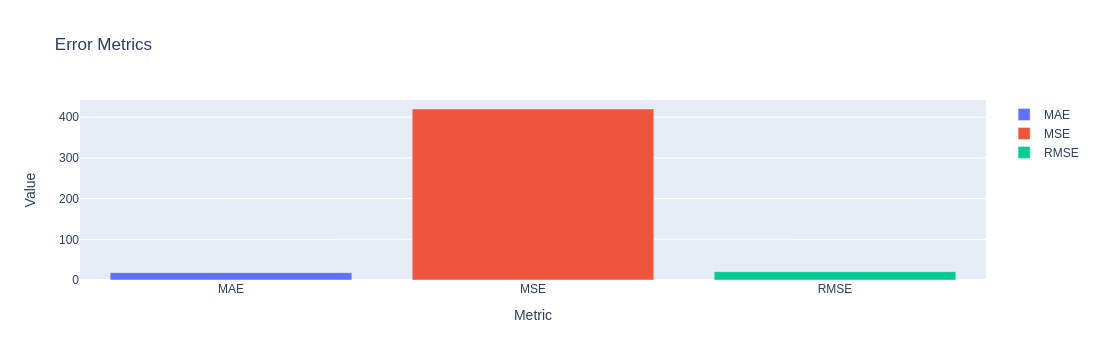

In [52]:
import plotly.graph_objs as go

hata_arima = {
    'Metrics': ['MAE', 'MSE', 'RMSE'],
    'Values': [mae_arima, mse_arima, rmse_arima]
}

# Her bir metrik için bir go.Bar oluşturup bir listeye ekleyin
traces_arima = [go.Bar(x=[metric], y=[value], name=metric) for metric, value in zip(hata_arima['Metrics'], hata_arima['Values'])]

# go.Figure ile grafiği oluşturun
fig = go.Figure(data=traces_arima)
fig.update_layout(
    title='Error Metrics',
    xaxis_title='Metric',
    yaxis_title='Value',
    showlegend=True  # Efsaneyi göster
)

# Grafiği göster
fig.show()


# LSTM

In [53]:
df_LSTM = pd.read_csv("file:///home/hduser/Desktop/NVDA/NVDA.csv")

In [54]:
df_LSTM.head()

,Date,Close
0,1999-03-22,0.424479
1,1999-03-23,0.398438
2,1999-03-24,0.395833
3,1999-03-25,0.401042
4,1999-03-26,0.436198


In [55]:
# Tarih sütununu datetime tipine çevirelim ve indeks olarak ayarlayalım
df_LSTM["Date"] = pd.to_datetime(df_LSTM["Date"])
df_LSTM.set_index("Date", inplace=True)

# Veri setinin son halini gösterelim
df_LSTM.head()


,Close
Date,
1999-03-22,0.424479
1999-03-23,0.398438
1999-03-24,0.395833
1999-03-25,0.401042
1999-03-26,0.436198


In [56]:
df_LSTM.isnull().sum()

Close    0
dtype: int64

In [57]:
#!pip install scikit-learn
#!pip install keras
#!pip install tensorflow

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_LSTM)

# Eğitim ve test setlerine ayırma
train_size = int(len(df_scaled) * 0.80)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]


In [59]:
import numpy as np

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [60]:
#pip install tensorflow
#pip install tensorflow==2.16.1

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# Örnek olarak, eğer her bir zaman adımında sadece 1 özellik (örneğin sadece kapanış fiyatı) varsa:
input_shape = (look_back, 1)

# Eğer birden fazla özellik varsa (örneğin hem kapanış fiyatı hem de hacim):
#input_shape = (look_back, 2)  # Bu, kullanılan özellik sayısına göre değişebilir

# Modelinizi oluşturun
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2024-04-02 22:16:48.685720: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 22:16:48.710824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 22:16:49.223362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-02 22:16:49.775839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 22:16:49.794487: 

In [62]:
# Modelinizi eğitim verileri ile eğitin
# Bu kod bloğu, X_train'in ve y_train'in uygun şekilde hazırlandığını varsayar
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
158/158 - 1s - 8ms/step - loss: 1.4137e-04
Epoch 2/10
158/158 - 0s - 943us/step - loss: 3.2106e-07
Epoch 3/10
158/158 - 0s - 904us/step - loss: 3.1580e-07
Epoch 4/10
158/158 - 0s - 923us/step - loss: 3.5425e-07
Epoch 5/10
158/158 - 0s - 894us/step - loss: 3.5976e-07
Epoch 6/10
158/158 - 0s - 936us/step - loss: 3.1073e-07
Epoch 7/10
158/158 - 0s - 940us/step - loss: 3.2850e-07
Epoch 8/10
158/158 - 0s - 895us/step - loss: 3.6071e-07
Epoch 9/10
158/158 - 0s - 901us/step - loss: 3.8613e-07
Epoch 10/10
158/158 - 0s - 886us/step - loss: 3.7667e-07


In [63]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
Train Score: 16.94 RMSE
Test Score: 258.20 RMSE


In [64]:
#!pip install keras-tuner

In [65]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch

# Model oluşturmak için fonksiyon
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)))  # X_train'in özellik sayısına bağlı olarak şekil değişebilir
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

# Tuner'ı tanımla
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_example' )

Reloading Tuner from my_dir/keras_tuner_example/tuner0.json


In [66]:
# Tuner ile hiperparametre aramasını başlat
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=5)])

In [67]:
best_hps = tuner.get_best_hyperparameters()[0]
print(f"En iyi hiperparametreler: {best_hps.values}")
#print(f"En iyi kayıp değeri (val_loss): {tuner.results_summary()}")

En iyi hiperparametreler: {'units': 64, 'dropout': 0.0, 'learning_rate': 0.001}


In [68]:
# En iyi hiperparametreleri al ve modeli yeniden oluştur
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6640e-06 - mean_squared_error: 4.6639e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6685e-06 - mean_squared_error: 3.6686e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5409e-06 - mean_squared_error: 3.5410e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6558e-06 - mean_squared_error: 3.6558e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4271e-06 - mean_squared_error: 3.4271e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5323e-06 - mean_squared_error: 3.5323e-06 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.61

In [69]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
#train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
#test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
Train Score: 0.0035 RMSE
Test Score: 0.0425 RMSE


In [70]:
model.save("modelim.h5")

In [71]:
df_real_close

,Close
Date,
2024-03-22,942.890015
2024-03-25,950.020020
2024-03-26,925.609985
2024-03-27,902.500000
2024-03-28,903.559998
2024-04-01,903.630005
2024-04-02,894.520020


In [72]:
df_LSTM.tail()

,Close
Date,
2024-03-15,878.369995
2024-03-18,884.549988
2024-03-19,893.979980
2024-03-20,903.719971
2024-03-21,914.349976


In [73]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import joblib 
import datetime as dt

In [74]:
# Pandas kullanarak iş günleri sayısını ve toplam gün sayısını hesaplayacağız


start_LSTM = df_LSTM.index.max()
start_LSTM = start_LSTM + pd.Timedelta(days=1)

# Bugünün tarihini alalım
end_LSTM = pd.to_datetime("today").normalize()  # Saat bilgisi olmadan bugünün tarihi

# İş günlerini hesaplayalım
business_days_LSTM = pd.bdate_range(start=start_LSTM, end=end_LSTM)

# İş günleri ve toplam gün sayısını -1 ile başlatalım çünkü başlangıç gününü saymıyoruz
weekdays_count_LSTM = len(business_days_LSTM) - 1
total_days_LSTM = (end_LSTM - start_LSTM).days - 1

weekdays_count_LSTM, total_days_LSTM


(7, 10)

In [75]:
# Model ve scaler yükleniyor. Yolları kontrol edin.
model = load_model("modelim.h5")
scaler = joblib.load("scaler.joblib")


close_prices = df_LSTM["Close"].values.reshape(-1, 1)

# Ölçeklenmiş son 10 fiyatı almak için:
look_back = 10  # Burada kaç önceki adımı kullanmak istediğinizi belirtin
last_prices_scaled = scaler.transform(close_prices[-look_back:])

# Tahminler için bir dizi oluşturun.
predictions = []


In [76]:
def predict_next_n_days(model, normalized_data, look_back, weekdays_count_LSTM):
    predictions = []
    # Normalleştirilmiş verileri modelin beklediği şekle getirme
    close_prices = df_LSTM["Close"].values.reshape(-1, 1)
    last_prices_scaled = scaler.transform(close_prices[-look_back:])
    # Tahminler için bir dizi oluşturun.
    predictions = []
    for i in range(weekdays_count_LSTM):
        # Model tahminini yapın ve sonucu ölçeklendirmeyi tersine çevirin.
        predicted_price_normalized = model.predict(last_prices_scaled)
        predicted_price_normalized = predicted_price_normalized.reshape(look_back, 1)
        predicted_price = scaler.inverse_transform(predicted_price_normalized)[1, -1]
        
        # Tahmin listesine ekleyin.
        predictions.append(predicted_price)
        
        # Son tahmin edilen fiyatı ölçeklendirin ve ölçeklenmiş fiyatlar listesine ekleyin.
        last_price_scaled = np.append(last_prices_scaled, predicted_price_normalized)[-look_back:]
        last_prices_scaled = last_prices_scaled.reshape(-1, 1)
    
    return predictions

In [77]:
predicted_prices = predict_next_n_days(model, close_prices, look_back, weekdays_count_LSTM)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [78]:
end_LSTM
# Tahmin tarihlerini oluşturun.
predicted_dates = pd.date_range(start=start_LSTM, periods=weekdays_count_LSTM, freq='B')

# Tahminleri içeren DataFrame oluşturun.
predictions_df = pd.DataFrame(data=predicted_prices, index=predicted_dates, columns=["Predicted_Close"])
predictions_df.index.name = "Date"
predictions_df

,Predicted_Close
Date,
2024-03-22,5.427067
2024-03-25,5.427067
2024-03-26,5.427067
2024-03-27,5.427067
2024-03-28,5.427067
2024-03-29,5.427067
2024-04-01,5.427067


In [79]:
# Kütüphaneleri yükle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import joblib


# Kapanış fiyatlarını seç
closing_prices = df_LSTM['Close'].values.reshape(-1, 1)

# Verileri ölçeklendir
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Verileri eğitim ve test setlerine ayır
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# LSTM için veri setini yeniden şekillendirme fonksiyonu
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


In [80]:
# Eğitim ve test veri setlerini oluştur
look_back = 16
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [81]:
# LSTM modelini oluştur
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Modeli derle
model.compile(loss='mean_squared_error', optimizer='adam')

# Modeli eğit
model.fit(X_train, y_train, epochs=10, batch_size=1024, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz

Epoch 1/10
5/5 - 1s - 245ms/step - loss: 2.0494e-04
Epoch 2/10
5/5 - 0s - 45ms/step - loss: 1.0006e-04
Epoch 3/10
5/5 - 0s - 43ms/step - loss: 2.8782e-05
Epoch 4/10
5/5 - 0s - 48ms/step - loss: 1.8029e-05
Epoch 5/10
5/5 - 0s - 46ms/step - loss: 1.3077e-05
Epoch 6/10
5/5 - 0s - 46ms/step - loss: 4.4692e-06
Epoch 7/10
5/5 - 0s - 50ms/step - loss: 5.7974e-06
Epoch 8/10
5/5 - 0s - 48ms/step - loss: 3.7834e-06
Epoch 9/10
5/5 - 0s - 45ms/step - loss: 2.0350e-06
Epoch 10/10
5/5 - 0s - 45ms/step - loss: 2.4441e-06


In [82]:
# Tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi tersine çevir
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Model performansını değerlendir
train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
print(f'Train Score: {train_score:.4f} RMSE')
print(f'Test Score: {test_score:.4f} RMSE')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 1.2346 RMSE
Test Score: 25.7708 RMSE


In [83]:
# Modeli ve ölçekleyiciyi kaydet
model.save('LSTM_model.h5')  # Modeli kaydetmek için h5 dosya formatını kullanıyoruz
joblib.dump(scaler, 'scaler.pkl')  # Ölçekleyiciyi kaydetmek için joblib kullanıyoruz

['scaler.pkl']

In [84]:
# Sonraki 6 iş günü için tarihler oluştur
last_date = df_LSTM.index[-1]
dates = pd.date_range(start=last_date, periods=6, freq='B')

# Tahminleri yap
predictions = model.predict(X_test)[-6:]  # Test setinin sonundan alınan 6 tahmin
predicted_prices = scaler.inverse_transform(predictions)

# Tahminleri içeren DataFrame oluştur
predictions_df = pd.DataFrame(data=predicted_prices, index=dates, columns=['Predicted_Close'])
predictions_df.index.name = "Date"
predictions_df

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Predicted_Close
Date,
2024-03-21,759.702820
2024-03-22,768.549622
2024-03-25,776.538452
2024-03-26,781.342285
2024-03-27,785.445618
2024-03-28,789.123169


# DASH

In [92]:
#!pip install dash
#!pip install dash-bootstrap-components


In [85]:
# Dash ve gerekli komponentlerin yüklenmesi
import dash
import time  # Model eğitimi simülasyonu için kullanılacak
from dash import html, dcc, State, Input, Output, callback, Dash, no_update
from dash.exceptions import PreventUpdate
import dash_bootstrap_components as dbc

#from dash.dependencies import Input, Output
import plotly.graph_objs as go

# Kullanılacak diğer kütüphaneler
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [147]:
import dash
from dash import html, dcc, callback, Dash
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import dash_bootstrap_components as dbc

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import time
import threading



app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100, style={"height": "30px"}),
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button', n_clicks=0),
    html.Div(id='training_output'),
    dcc.Interval(id='progress_interval', interval=1000, n_intervals=0)
])

# @callback(
#     Output('training_output', 'children'),
#     Output('progress_bar', 'value'),
#     Input('train_button', 'n_clicks'),
#     State('look_back_input', 'value'),
#     State('epochs_input', 'value'),
#     State('batch_size_input', 'value'),
#     prevent_initial_call=True
# )


# İlerleme durumunu kontrol etmek için global değişkenler
global progress_value, train_output, is_training
progress_value = 0
train_output = ""
is_training = False

def toggle_interval(n_clicks, is_disabled):
    if n_clicks > 0:
        return not is_disabled
    return is_disabled

@app.callback(
    Output('progress_bar', 'value'),
    Input('progress_interval', 'n_intervals')
)
def update_progress_bar(n_intervals):
    global progress_value
    return progress_value

@app.callback(
    Output('training_output', 'children'),
    Input('progress_interval', 'n_intervals')
)
def update_output(n_intervals):
    global train_output
    return train_output

@app.callback(
    Output('train_button', 'n_clicks'),
    Input('progress_interval', 'n_intervals'),
    [State('look_back_input', 'value'), 
     State('epochs_input', 'value'), 
     State('batch_size_input', 'value')],
    prevent_initial_call=True
)



@app.callback(
    [Output('training_output', 'children'), Output('progress_bar', 'value')],
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')],
    prevent_initial_call=True
)
def train_model(n_clicks, look_back, epochs, batch_size):
    if n_clicks > 0:
        # Model eğitim kodları burada yer alacak
        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)

        # Veri setlerini yeniden şekillendir
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # LSTM modelini oluştur
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        # Modeli derle
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Modeli eğit ve her epoch sonunda ilerlemeyi güncelle
        for epoch in range(epochs):
            model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0)
            progress_value = int(((epoch + 1) / epochs) * 100)

            # Eğitim sürecini güncelle
            train_output = f"Epoch {epoch + 1}/{epochs} tamamlandı."
            
            yield train_output, progress_value
        
        # Tahmin yap
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # Ölçeklendirmeyi tersine çevir
        train_predict = scaler.inverse_transform(train_predict)
        y_train = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test = scaler.inverse_transform([y_test])

        # Model performansını değerlendir
        train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
        test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
        
        # Eğitim tamamlandıktan sonra sonuçları döndür
        final_output = [
            html.P(f"Train Score: {train_score:.4f} RMSE"),
            html.P(f"Test Score: {test_score:.4f} RMSE")
        ]

        return final_output, 100
    else:
        raise PreventUpdate

if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
SchemaTypeValidationError                 Traceback (most recent call last)
SchemaTypeValidationError: Schema: [<Output `training_output.children`>, <Output `progress_bar.value`>]
Path: ()
Expected type: (<class 'tuple'>, <class 'list'>)
Received value of type <class 'generator'>:
    <generator object train_model at 0x7f20f6ac33e0>



In [145]:
# Dash ve gerekli komponentlerin yüklenmesi
import dash
from dash import html, dcc, callback, Dash
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import dash_bootstrap_components as dbc

# Kullanılacak diğer kütüphaneler
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import time
import threading

# Global değişkenler
progress_value = 0
is_training = False
look_back_input = 10

# Dash uygulamasının başlatılması
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button', n_clicks=0),
    html.Div(id='model_output'),
    dcc.Interval(id='progress_interval', interval=1000, n_intervals=0)
])

@app.callback(
    Output('progress_bar', 'value'),
    Input('progress_interval', 'n_intervals')
)
def update_progress_bar(n):
    global progress_value
    return progress_value



# @app.callback(
#     [Output('model_output', 'children'), Output('progress_bar', 'value')],
#     [Input('train_button', 'n_clicks')],
#     [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')],
#     prevent_initial_call=True
# )
@app.callback(
    [Output('model_output', 'children'), Output('progress_interval', 'disabled')],
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')],
    prevent_initial_call=True
)
def toggle_interval(n_clicks, look_back_input, epochs_input, batch_size_input):
    return False if n_clicks and not is_training else True

def update_output(n_clicks, look_back_input, epochs_input, batch_size_input):
    def train_model():
        global progress_value, is_training
        is_training = True
        # Modelin eğitim sonuçlarını biriktireceğimiz bir string
        training_output = ""
        
        for i in range(1, epochs_input + 1):
            # Eğitim işlemleri ve çıktılarının burada yapılacağını varsayıyoruz.
            #Eğitim ve test veri setlerini oluştur
            #look_back = look_back
            X_train, y_train = create_dataset(train_data, look_back_input)
            X_test, y_test = create_dataset(test_data, look_back_input)
            
            # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
            # LSTM modelini oluştur
            model = Sequential()
            model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
            model.add(LSTM(units=50))
            model.add(Dense(1))
            # Modeli derle
            model.compile(loss='mean_squared_error', optimizer='adam')
            # Modeli eğit
            model.fit(X_train, y_train, epochs=epochs_input, batch_size=batch_size_input, verbose=2)
            
            # Tahmin yap
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)
            
            # Ölçeklendirmeyi tersine çevir
            train_predict = scaler.inverse_transform(train_predict)
            y_train = scaler.inverse_transform([y_train])
            test_predict = scaler.inverse_transform(test_predict)
            y_test = scaler.inverse_transform([y_test])
            
            # Model performansını değerlendir
            train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
            test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
            print(f'Train Score: {train_score:.4f} RMSE')
            print(f'Test Score: {test_score:.4f} RMSE')
            # ...
            time.sleep(1)  # Simülasyon için bekleme
            progress_value = int((i / epochs_input) * 100)
            
            # Simüle edilmiş çıktıyı ekleyin
            training_output += f"Epoch {i}/{epochs_input} - Loss: Simulated\n"
            
        # Eğitim tamamlandığında, çıktıları ve ilerleme durumunu döndür
        is_training = False
        return html.Div([
            html.Pre(training_output, style={'white-space': 'pre-wrap'}),
            html.P("Eğitim tamamlandı.")
        ]), progress_value

    if not is_training:
        threading.Thread(target=train_model).start()
        return html.Div("Model eğitiliyor..."), progress_value
    else:
        # Eğitim zaten başlamışsa, mevcut çıktıyı ve ilerleme durumunu güncelle
        return no_update, progress_value

if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
SchemaTypeValidationError                 Traceback (most recent call last)
SchemaTypeValidationError: Schema: [<Output `model_output.children`>, <Output `progress_interval.disabled`>]
Path: ()
Expected type: (<class 'tuple'>, <class 'list'>)
Received value of type <class 'bool'>:
    False



In [137]:
# Dash ve gerekli komponentlerin yüklenmesi
import dash
from dash import html, dcc, callback, Dash
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import dash_bootstrap_components as dbc

# Kullanılacak diğer kütüphaneler
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import time
import threading

# Global değişkenler
progress_value = 0
is_training = False
look_back_input = 10

# Dash uygulamasının başlatılması
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button', n_clicks=0),
    html.Div(id='model_output'),
    dcc.Interval(id='progress_interval', interval=1000, n_intervals=0)
])

@app.callback(
    Output('progress_bar', 'value'),
    Input('progress_interval', 'n_intervals')
)
def update_progress_bar(n):
    global progress_value
    return progress_value

@app.callback(
    [Output('model_output', 'children'), Output('progress_interval', 'disabled')],
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')],
    prevent_initial_call=True
)
def update_output(n_clicks, look_back_input, epochs_input, batch_size_input):
    def train_model():
        global progress_value, is_training
        is_training = True
        # Eğitim kodları burada yer alacak. `create_dataset` fonksiyonunu tanımlamayı unutmayın.
        # Eğitim ve test veri setlerini oluştur
        #look_back = look_back
        X_train, y_train = create_dataset(train_data, look_back_input)
        X_test, y_test = create_dataset(test_data, look_back_input)
        
        # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        # LSTM modelini oluştur
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))
        # Modeli derle
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Modeli eğit
        model.fit(X_train, y_train, epochs=epochs_input, batch_size=batch_size_input, verbose=2)
        
        # Tahmin yap
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        
        # Ölçeklendirmeyi tersine çevir
        train_predict = scaler.inverse_transform(train_predict)
        y_train = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test = scaler.inverse_transform([y_test])
        
        # Model performansını değerlendir
        train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
        test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
        print(f'Train Score: {train_score:.4f} RMSE')
        print(f'Test Score: {test_score:.4f} RMSE')
        # Simülasyon için döngü
        for i in range(1, epochs_input + 1):
            time.sleep(1)  # Simülasyon için bekleme
            progress_value = int((i / epochs_input) * 100)
            # Burada eğitim işlemleri gerçekleştirilecek.

        is_training = False
        return "Eğitim tamamlandı.", True

    if not is_training:
        threading.Thread(target=train_model).start()
        return "Model eğitiliyor...", False
    return dash.no_update, dash.no_update

if __name__ == '__main__':
    app.run_server(debug=True)


Epoch 1/5
157/157 - 4s - 28ms/step - loss: 0.2050
Epoch 2/5
157/157 - 0s - 2ms/step - loss: 5.5036e-08
Epoch 3/5
157/157 - 0s - 2ms/step - loss: 6.5553e-15
Epoch 4/5
157/157 - 0s - 2ms/step - loss: 0.0000e+00
Epoch 5/5
157/157 - 0s - 2ms/step - loss: 0.0000e+00
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 0.0000 RMSE
Test Score: 0.0000 RMSE


In [136]:
from dash import Dash, html, dcc, Input, Output, State
import dash_bootstrap_components as dbc
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import time
import threading

# Örnek için basit bir veri seti oluşturma fonksiyonu
#def create_dataset(data, look_back):          
    

# Global değişkenler
progress_value = 0
is_training = False
look_back_input= 10

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button', n_clicks=0),
    html.Div(id='model_output'),
    dcc.Interval(id='progress_interval', interval=1000, n_intervals=0)
])

@app.callback(
    Output('progress_bar', 'value'),
    Input('progress_interval', 'n_intervals')
)
def update_progress_bar(n):
    global progress_value
    return progress_value

@app.callback(
    Output('model_output', 'children'),
    Output('progress_interval', 'disabled'),
    Input('train_button', 'n_clicks'),
    State('look_back_input', 'value'),
    State('epochs_input', 'value'),
    State('batch_size_input', 'value'),
    prevent_initial_call=True
)

def update_output(n_clicks, look_back_input, epochs_input, batch_size_input):
    def train_model():
        global progress_value, is_training, look_back_input
        is_training = True
        # Eğitim kodları burada yer alacak
        for i in range(1, epochs_input + 1):
            # Eğitim adımlarınız...
            time.sleep(1)  # Simülasyon için bekleme
            progress_value = int((i / epochs_input) * 100)
            
            # Eğitim ve test veri setlerini oluştur
            #look_back = look_back
            X_train, y_train = create_dataset(train_data, look_back_input)
            X_test, y_test = create_dataset(test_data, look_back_input)
            
            # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
            # LSTM modelini oluştur
            model = Sequential()
            model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
            model.add(LSTM(units=50))
            model.add(Dense(1))
            # Modeli derle
            model.compile(loss='mean_squared_error', optimizer='adam')
            # Modeli eğit
            model.fit(X_train, y_train, epochs=epochs_input, batch_size=batch_size_input, verbose=2)
            
            # Tahmin yap
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)
            
            # Ölçeklendirmeyi tersine çevir
            train_predict = scaler.inverse_transform(train_predict)
            y_train = scaler.inverse_transform([y_train])
            test_predict = scaler.inverse_transform(test_predict)
            y_test = scaler.inverse_transform([y_test])
            
            # Model performansını değerlendir
            train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
            test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
            print(f'Train Score: {train_score:.4f} RMSE')
            print(f'Test Score: {test_score:.4f} RMSE')

            
            # Eğitim süreci ve sonuçları için metin mesajları oluşturun
            training_status = "Model eğitiliyor..."
            training_results = "Eğitim tamamlandı. Sonuçlar burada gösterilecek."
            # İlerleme çubuğunu güncelleyin (örneğin her epoch için %10 ilerleme varsayalım)
            progress = (current_epoch / epochs_input) * 100
            # Çıktıyı HTML formatında döndürün
            return html.Div([
                html.P(training_status),
                html.P(training_results)
            ]), progress
            
        is_training = False

    global is_training
    if not is_training:
        threading.Thread(target=train_model).start()
        return "Model eğitiliyor...", False
    return no_update, no_update

if __name__ == '__main__':
    app.run_server(debug=True)


Epoch 1/2
157/157 - 4s - 28ms/step - loss: 0.1955
Epoch 2/2
157/157 - 0s - 2ms/step - loss: 4.1806e-08
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Score: 0.0004 RMSE
Test Score: 0.0004 RMSE


Exception in thread Thread-10807 (train_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/hduser/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_15294/2746397319.py", line 102, in train_model
NameError: name 'current_epoch' is not defined


In [119]:
from dash import Dash, html, dcc, Input, Output, State
import dash_bootstrap_components as dbc
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import time
import threading

# Örnek için basit bir veri seti oluşturma fonksiyonu
def create_dataset(data, look_back):
    # Veri seti oluşturma kodunuz buraya gelecek
    return np.array([[1]] * (len(data) - look_back)), np.array([1] * (len(data) - look_back))

# Global değişkenler
progress_value = 0
is_training = False

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button', n_clicks=0),
    html.Div(id='model_output'),
    dcc.Interval(id='progress_interval', interval=1000, n_intervals=0)
])

@app.callback(
    Output('progress_bar', 'value'),
    Input('progress_interval', 'n_intervals')
)
def update_progress_bar(n):
    global progress_value
    return progress_value

@app.callback(
    Output('model_output', 'children'),
    Output('progress_interval', 'disabled'),
    Input('train_button', 'n_clicks'),
    State('look_back_input', 'value'),
    State('epochs_input', 'value'),
    State('batch_size_input', 'value'),
    prevent_initial_call=True
)
def update_output(n_clicks, look_back, epochs, batch_size):
    def train_model():
        global progress_value, is_training
        is_training = True
        # Eğitim kodları burada yer alacak
        for i in range(1, epochs + 1):
            # Eğitim adımlarınız...
            time.sleep(1)  # Simülasyon için bekleme
            progress_value = int((i / epochs) * 100)
            
            # Eğitim ve test veri setlerini oluştur
            look_back = look_back
            X_train, y_train = create_dataset(train_data, look_back)
            X_test, y_test = create_dataset(test_data, look_back)
            
            # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
            # LSTM modelini oluştur
            model = Sequential()
            model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
            model.add(LSTM(units=50))
            model.add(Dense(1))
            
            # Modeli derle
            model.compile(loss='mean_squared_error', optimizer='adam')
            # Modeli eğit
            model.fit(X_train, y_train, epochs=epochs_input, batch_size=batch_size_input, verbose=2)
            
            # Tahmin yap
            train_predict = model.predict(X_train)
            test_predict = model.predict(X_test)
            
            # Ölçeklendirmeyi tersine çevir
            train_predict = scaler.inverse_transform(train_predict)
            y_train = scaler.inverse_transform([y_train])
            test_predict = scaler.inverse_transform(test_predict)
            y_test = scaler.inverse_transform([y_test])
            
            # Model performansını değerlendir
            train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
            test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
            print(f'Train Score: {train_score:.4f} RMSE')
            print(f'Test Score: {test_score:.4f} RMSE')

            
            
        is_training = False

    global is_training
    if not is_training:
        threading.Thread(target=train_model).start()
        return "Model eğitiliyor...", False
    return no_update, no_update

if __name__ == '__main__':
    app.run_server(debug=True)


Exception in thread Thread-5661 (train_model):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/hduser/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: update_output.<locals>.train_model() missing 1 required positional argument: 'look_back'


In [97]:
import time
import threading
from dash import Dash, html, dcc, Input, Output, State

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    
    dcc.Loading(id="loading-1", children=[html.Div(id="loading-output-1")], type="default"),
    html.Button('Modeli Eğit', id='train-button', n_clicks=0),

    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    

    
    dbc.Progress(id='progress-bar', value=0, max=100),
    dcc.Interval(id='progress-interval', interval=1*1000, n_intervals=0)  # Her 1 saniyede bir tetiklenir
])

def train_model(look_back, epochs, batch_size, update_progress):
    # Burada gerçek model eğitimi kodunuzu yazın.
    # Eğitim ve test veri setlerini oluştur
    look_back = look_back
    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)
    
    # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # LSTM modelini oluştur
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    
    # Modeli derle
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Modeli eğit
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz
    
    # Tahmin yap
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Ölçeklendirmeyi tersine çevir
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])
    
    # Model performansını değerlendir
    train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
    test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
    print(f'Train Score: {train_score:.4f} RMSE')
    print(f'Test Score: {test_score:.4f} RMSE')

    
    # # Örnek olarak, her epoch'ta bir saniye bekleme ekledim.
    # for i in range(1, epochs + 1):
    #     time.sleep(1)  # Model eğitimini simüle etmek için zaman gecikmesi
    #     progress = int((i / epochs) * 100)
    #     update_progress(progress)  # İlerlemeyi güncelle

# Arka planda çalışacak fonksiyon
def train_model_in_background(n_clicks, look_back, epochs, batch_size):
    # İlerleme barını güncellemek için kullanılacak iç callback fonksiyonu.
    def update_progress(progress):
        app.push_modifications('progress-bar', {'value': progress})

    # Model eğitimi iş parçacığını başlat
    thread = threading.Thread(target=train_model, args=(look_back, epochs, batch_size, update_progress))
    thread.start()

# Callback'ı tanımlayın
@app.callback(
    Output('loading-output-1', 'children'),
    [Input('train-button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')]
)
def update_output(n_clicks, look_back, epochs, batch_size):
    if n_clicks > 0:
        train_model_in_background(n_clicks, look_back, epochs, batch_size)
        return f"Model eğitiliyor... Look back: {look_back}, Epochs: {epochs}, Batch Size: {batch_size}"
    return "Eğitimi başlatmak için 'Modeli Eğit' düğmesine basın."

if __name__ == '__main__':
    app.run_server(debug=True)


Epoch 1/10
157/157 - 2s - 11ms/step - loss: 1.5869e-05
Epoch 2/10
157/157 - 1s - 3ms/step - loss: 1.6794e-06
Epoch 3/10
157/157 - 1s - 3ms/step - loss: 1.4574e-06
Epoch 4/10
157/157 - 0s - 3ms/step - loss: 1.6569e-06
Epoch 5/10
157/157 - 1s - 3ms/step - loss: 1.8315e-06
Epoch 6/10
157/157 - 1s - 3ms/step - loss: 1.2349e-06
Epoch 7/10
157/157 - 1s - 4ms/step - loss: 1.3685e-06
Epoch 8/10
157/157 - 1s - 4ms/step - loss: 1.6055e-06
Epoch 9/10
157/157 - 1s - 3ms/step - loss: 1.5238e-06
Epoch 10/10
157/157 - 1s - 4ms/step - loss: 1.1725e-06
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 0.8654 RMSE
Test Score: 22.9435 RMSE


In [108]:
app = Dash(__name__)

# Uygulama düzeni ve geri aramaları...

# Model eğitimi sırasında gösterilecek ilerleme çubuğu bileşeni
#progress_bar = dbc.Progress(value=0, max=100, id='progress_bar')

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    
    html.Button('Modeli Eğit', id='train_button'),
    html.Div(id='model_output'),
    
    

    #progress_bar,
    # İlerleme çubuğunu güncellemek için interval bileşeni
    dcc.Interval(id='interval', interval=1000, n_intervals=0)
])

# Model eğitimi callback'ı
@app.callback(
    [Output('model_output', 'children'), Output('progress_bar', 'value')],
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')]
)



def update_output(n_clicks, look_back, epochs, batch_size):
    if n_clicks is None:
        raise PreventUpdate

    for i in range(1, epochs + 1):
        
        # Burada model eğitimi kodunuzu çalıştıracaksınız.
        # Şimdilik zaman gecikmesi ile simülasyon yapacağız.

        # Eğitim ve test veri setlerini oluştur
        look_back = look_back
        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)
        
        # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        # LSTM modelini oluştur
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))
        
        # Modeli derle
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Modeli eğit
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz
        
        # Tahmin yap
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        
        # Ölçeklendirmeyi tersine çevir
        train_predict = scaler.inverse_transform(train_predict)
        y_train = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test = scaler.inverse_transform([y_test])
        
        # Model performansını değerlendir
        train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
        test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
        print(f'Train Score: {train_score:.4f} RMSE')
        print(f'Test Score: {test_score:.4f} RMSE')


        
        progress = int((i / epochs) * 100)  # İlerlemeyi hesapla
        return f"Eğitim Tamamlandı. Look back: {look_back}, Epochs: {epochs}, Batch Size: {batch_size}", progress
    return no_update, no_update

if __name__ == '__main__':
    app.run_server(debug=True)
    #app.run_server(debug=True, port=8051)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File ~/.local/lib/python3.10/site-packages/dash/dash.py:1295, in Dash.dispatch(self=<dash.dash.Dash object>)
   1294 try:
-> 1295     cb = self.callback_map[output]
        output = 'progress_bar.value'
        self.callback_map = {'..model_output.children...progress_bar.value..': {'inputs': [{'id': 'train_button', 'property': 'n_clicks'}], 'state': [{'id': 'look_back_input', 'property': 'value'}, {'id': 'epochs_input', 'property': 'value'}, {'id': 'batch_size_input', 'property': 'value'}], 'outputs_indices': [0, 1], 'inputs_state_indices': [0, 1, 2, 3], 'long': None, 'output': [<Output `model_output.children`>, <Output `progress_bar.value`>], 'raw_inputs': [<Input `train_button.n_clicks`>], 'manager': None, 'allow_dynamic_callbacks': None, 'callback': <function update_output at 0x7f21a3b1bd00>}}
        self = <dash.dash.Dash object at

In [ ]:
# Dash uygulamasını başlat
app = dash.Dash(__name__)

# Uygulama düzenini tanımla
app.layout = html.Div([
    dcc.Input(id='look_back_input', type='number', value=100),
    dcc.Input(id='epochs_input', type='number', value=10),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button'),
    html.Div(id='model_output')
])

# Callback tanımı
@app.callback(
    Output('model_output', 'children'),
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'),
     State('epochs_input', 'value'),
     State('batch_size_input', 'value')]
)
def update_output(n_clicks, look_back, epochs, batch_size):
    if n_clicks is None:
        raise PreventUpdate
    
    # Model eğitimini burada yap
    # ... model oluşturma ve eğitim kısmınızı buraya ekleyin ...
    
    # Modeli eğit ve skorları hesapla
    # ... skorları hesaplayın ...
    
    return f'Train Score: {train_score:.4f} RMSE, Test Score: {test_score:.4f} RMSE'

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)
    #app.run_server(debug=True, port=8051)

In [ ]:
# Dash uygulamasını başlat
app = dash.Dash(__name__)

# Uygulama düzenini tanımla
app.layout = html.Div([
    dcc.Input(id='look_back_input', type='number', value=100),
    dcc.Input(id='epochs_input', type='number', value=10),
    dcc.Input(id='batch_size_input', type='number', value=32),
    html.Button('Modeli Eğit', id='train_button'),
    html.Div(id='model_output')
])

# Callback tanımı
@app.callback(
    Output('model_output', 'children'),
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'),
     State('epochs_input', 'value'),
     State('batch_size_input', 'value')]
)
def update_output(n_clicks, look_back, epochs, batch_size):
    if n_clicks is None:
        raise PreventUpdate
    
    # Eğitim ve test veri setlerini oluştur
    look_back = 16
    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)
    
    # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # LSTM modelini oluştur
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    
    # Modeli derle
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Modeli eğit
    model.fit(X_train, y_train, epochs=500, batch_size=1024, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz
    
    # Tahmin yap
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Ölçeklendirmeyi tersine çevir
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])
    
    # Model performansını değerlendir
    train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
    test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
    print(f'Train Score: {train_score:.4f} RMSE')
    print(f'Test Score: {test_score:.4f} RMSE')

 
    return f'Train Score: {train_score:.4f} RMSE, Test Score: {test_score:.4f} RMSE'

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)
    #app.run_server(debug=True, port=8051)

In [ ]:
#pip install dash-bootstrap-components


In [ ]:
app = Dash(__name__)

# Uygulama düzeni ve geri aramaları...

# Model eğitimi sırasında gösterilecek ilerleme çubuğu bileşeni
#progress_bar = dbc.Progress(value=0, max=100, id='progress_bar')

app.layout = html.Div([
    dbc.Progress(id='progress_bar', value=0, max=100),
    
    html.Label('Look back:'),
    dcc.Input(id='look_back_input', type='number', value=10),
    
    html.Label('Epochs:'),
    dcc.Input(id='epochs_input', type='number', value=10),
    
    html.Label('Batch Size:'),
    dcc.Input(id='batch_size_input', type='number', value=32),
    
    html.Button('Modeli Eğit', id='train_button'),
    html.Div(id='model_output'),
    
    

    #progress_bar,
    # İlerleme çubuğunu güncellemek için interval bileşeni
    dcc.Interval(id='interval', interval=1000, n_intervals=0)
])

# Model eğitimi callback'ı
@app.callback(
    [Output('model_output', 'children'), Output('progress_bar', 'value')],
    [Input('train_button', 'n_clicks')],
    [State('look_back_input', 'value'), State('epochs_input', 'value'), State('batch_size_input', 'value')]
)



def update_output(n_clicks, look_back, epochs, batch_size):
    if n_clicks is None:
        raise PreventUpdate

    for i in range(1, epochs + 1):
        
        # Burada model eğitimi kodunuzu çalıştıracaksınız.
        # Şimdilik zaman gecikmesi ile simülasyon yapacağız.

        # Eğitim ve test veri setlerini oluştur
        look_back = look_back
        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)
        
        # Veri setlerini yeniden şekillendir (LSTM için 3D formatına)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        # LSTM modelini oluştur
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))
        
        # Modeli derle
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Modeli eğit
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)  # Daha fazla epoch ile daha iyi sonuçlar alabilirsiniz
        
        # Tahmin yap
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        
        # Ölçeklendirmeyi tersine çevir
        train_predict = scaler.inverse_transform(train_predict)
        y_train = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test = scaler.inverse_transform([y_test])
        
        # Model performansını değerlendir
        train_score = np.sqrt(np.mean((y_train[0] - train_predict[:, 0])**2))
        test_score = np.sqrt(np.mean((y_test[0] - test_predict[:, 0])**2))
        print(f'Train Score: {train_score:.4f} RMSE')
        print(f'Test Score: {test_score:.4f} RMSE')


        
        progress = int((i / epochs) * 100)  # İlerlemeyi hesapla
        return f"Eğitim Tamamlandı. Look back: {look_back}, Epochs: {epochs}, Batch Size: {batch_size}", progress
    return no_update, no_update

if __name__ == '__main__':
    app.run_server(debug=True)
    #app.run_server(debug=True, port=8051)